# Skew Correction

In [1]:
from scripts.skew_correction import skew_correction
import os

all_images_folder = './dataset/original_images'

for filename in os.listdir(all_images_folder):
    file_path = os.path.join(all_images_folder, filename)
    
    if os.path.isfile(file_path):
        skew_correction(file_path)

In [2]:
import matplotlib.pyplot as plt 
import cv2
import numpy as np
from scripts.mn_ocr_paddle.PaddleOCR.tools.infer.predict_rec import predict_custom

IMAGE_PATH = "./dataset/corrected_images/img_001.jpg"

In [3]:
# Print image with original size
def display_image(im_data, dpi = 100):

    if len(im_data.shape)==3:
        height, width, depth = im_data.shape
    else:
        height, width = im_data.shape
    figsize = width / float(dpi), height / float(dpi)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    ax.axis('off')
    ax.imshow(im_data, cmap='gray')

    plt.show()

# Convert gray image to rgb image
def convert_gray_to_rgb(gray_image):
    rgb_image = np.zeros_like(gray_image[:, :, np.newaxis]) * 255
    
    rgb_image = np.stack([gray_image] * 3, axis=-1)
    
    return rgb_image

# Apply preprocessing that is not done in skew correction
def apply_preprocess(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return gray

# Paragraph Segmentation

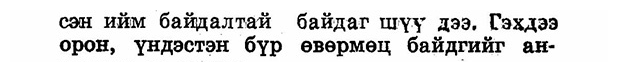

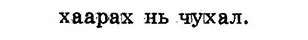

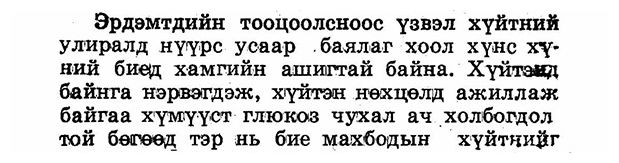

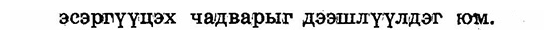

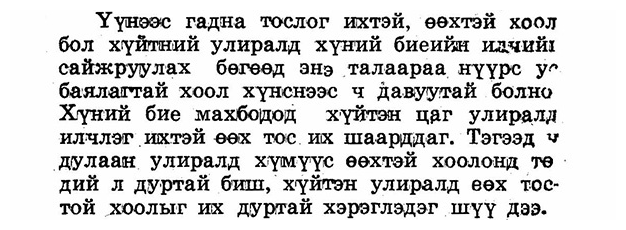

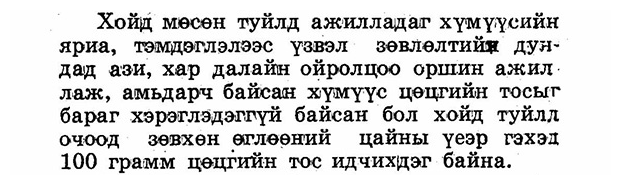

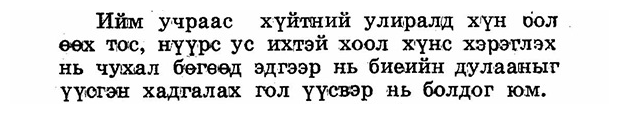

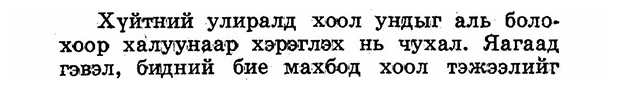

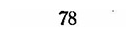

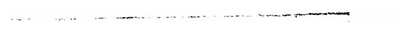

In [4]:
def get_contour_precedence(contour, cols):
    tolerance_factor = 61
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

def sort_contours_by_y(contours):
    bounding_boxes = [cv2.boundingRect(c) for c in contours]    
    sorted_indices = sorted(range(len(bounding_boxes)), key=lambda k: bounding_boxes[k][1])
    
    return [contours[i] for i in sorted_indices]

def detect_cntr(img_path):
    image = apply_preprocess(img_path)

    ret,thresh = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)

    kernel = np.ones((5,100), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    contours, h = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    

    image_area = image.shape[0] * image.shape[1]
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    largest_contour_area = w * h
    threshold_area = 0.95 * image_area
    if largest_contour_area >= threshold_area:
        contours = tuple(x for x in contours if x is not largest_contour)

    min_area = 1000
    contours_sorted = sort_contours_by_y(contours)

    filtered_contours = [contour for contour in contours_sorted if min_area <= cv2.contourArea(contour)]

    cropped_images = []
    for i, ctr in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(ctr)
        cropped_img = image[y:y+h, x:x+w]
        cropped_images.append(cropped_img)
        display_image(cropped_img)
    return cropped_images

contour_images = detect_cntr(IMAGE_PATH)

# Line Segmentation

In [5]:
def thresholding(image, inv=True):
    if inv:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    return thresh

In [6]:
def line_segmentation_horizontal_projection(gray_image):
    _, binary = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV)
    horizontal_projection = np.sum(binary, axis=1)

    threshold = (np.max(horizontal_projection) - np.min(horizontal_projection)) / 100
    lines = []
    start = None

    for i, value in enumerate(horizontal_projection):
        if value > threshold and start is None:  # Start of a line
            start = i
        elif value <= threshold and start is not None:  # End of a line
            end = i
            lines.append((start, end))
            start = None

    if start is not None:
        lines.append((start, len(horizontal_projection)))

    line_images = []
    for (start, end) in lines:
        x, y, w, h = 0, int(start), int(gray_image.shape[1]), int(end-start)
        line_images.append(gray_image[y:y+h, x:x+w])

    return line_images

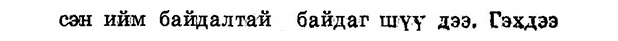

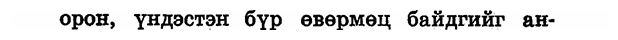

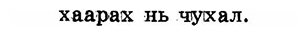

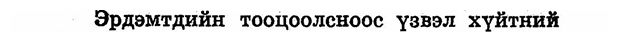

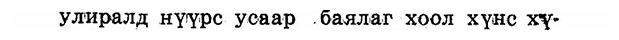

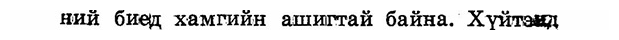

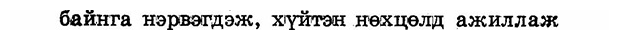

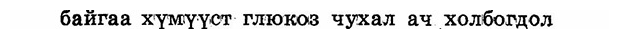

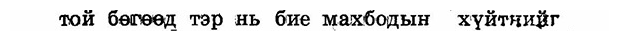

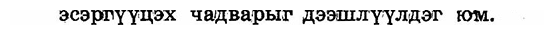

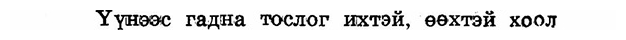

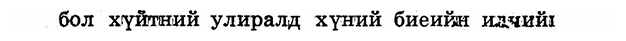

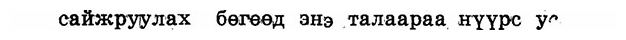

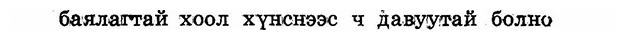

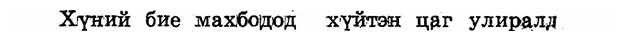

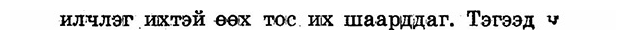

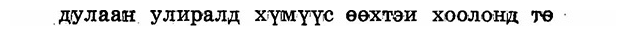

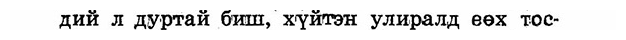

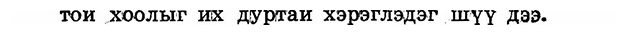

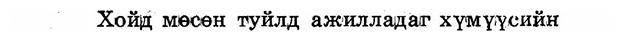

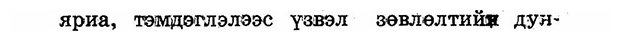

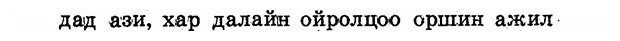

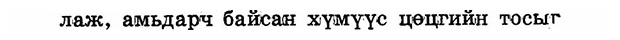

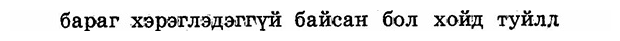

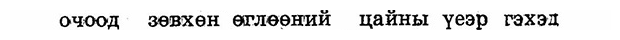

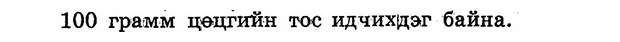

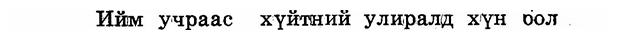

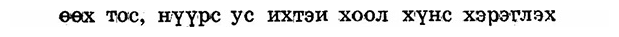

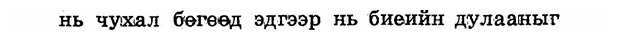

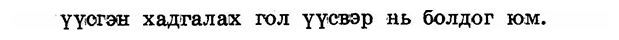

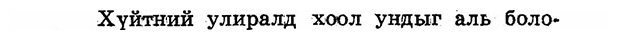

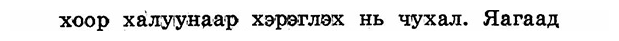

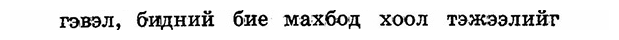

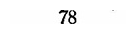

In [7]:
line_images_all = []
for i in range(len(contour_images)):
    line_images = line_segmentation_horizontal_projection(contour_images[i])
    if line_images != None:
        for single_line in line_images:
            if single_line.shape[0] > 10: #change
                line_images_all.append(single_line)
                display_image(single_line)

# Word Segmentation

In [8]:
def cropp_line(line_image):
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    height = line_image.shape[0]
    index = 0       
    while vertical_projection[index] == height:
        index += 1
    if index > 2:
        index -= 2
    line_image = line_image[:, index:]
    
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    
    index = line_image.shape[1] - 1
    while vertical_projection[index] == height:
        index -= 1
    if index < line_image.shape[1] - 1:
        index += 2
    
    line_image = line_image[:, :index]
    return line_image

def word_segmentation(line_image, display_result=False):
    line = cropp_line(line_image)
    dst = cv2.fastNlMeansDenoising(line, None, 12, 7, 21)
    thresh = thresholding(dst)
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1) 
    binary = line > dilated
    vertical_projection = np.sum(binary, axis=0)
    
    height = line.shape[0]
    whitespace_lengths = []
    current_whitespace = 0
    for vp in vertical_projection:
        if vp == height:
            current_whitespace += 1
        elif current_whitespace:
            whitespace_lengths.append(current_whitespace)
            current_whitespace = 0

    if current_whitespace:
        whitespace_lengths.append(current_whitespace)

    avg_white_space_length = np.mean(whitespace_lengths)*1.5 if whitespace_lengths else 0
    
    divider_indexes = [0]
    current_whitespace = 0
    for index, vp in enumerate(vertical_projection):
        if vp == height:
            current_whitespace += 1
        else:
            if current_whitespace > avg_white_space_length:
                divider_indexes.append(index - current_whitespace // 2)
            current_whitespace = 0

    if display_result:
        line_copy = line.copy()
        mask = np.zeros_like(line_copy, dtype=bool)
        mask[:, divider_indexes] = True
        line_copy[mask] = 0

        plt.figure(figsize=(6,15))
        plt.imshow(line_copy, cmap="gray")
        plt.show()
    
    divider_indexes.append(len(vertical_projection))

    dividers = np.column_stack((divider_indexes[:-1], divider_indexes[1:]))
    
    words = [line[:, window[0]:window[1]] for window in dividers]

    return words

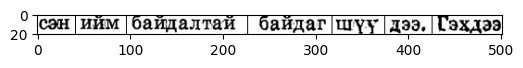

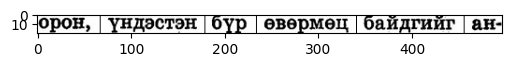

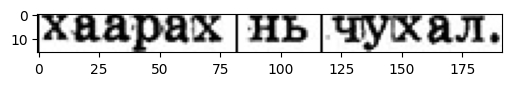

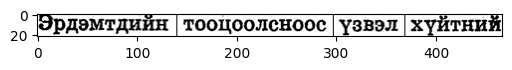

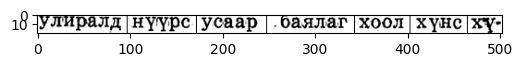

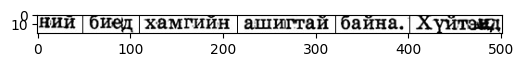

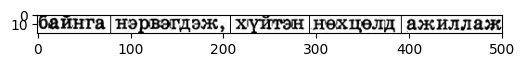

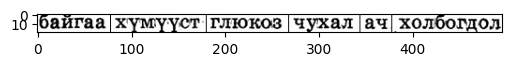

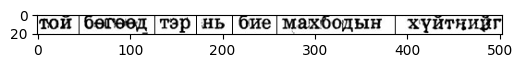

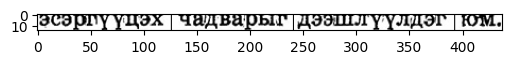

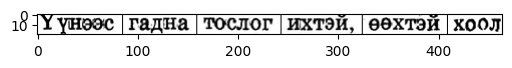

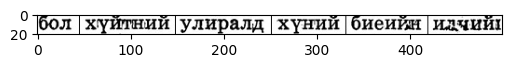

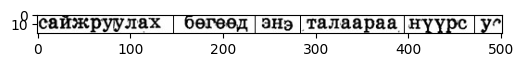

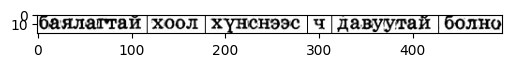

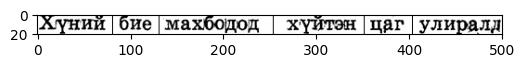

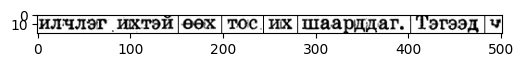

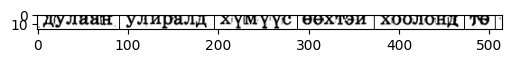

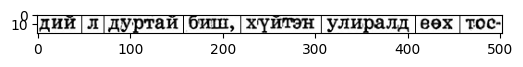

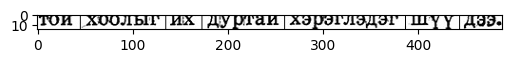

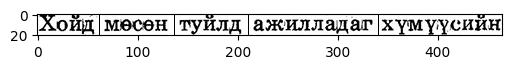

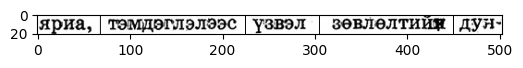

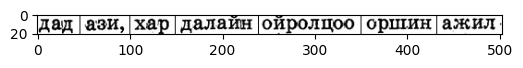

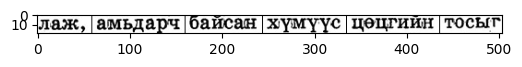

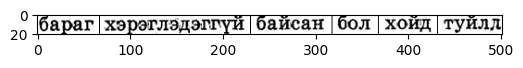

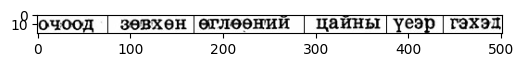

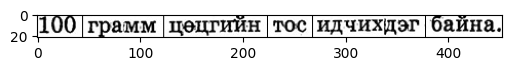

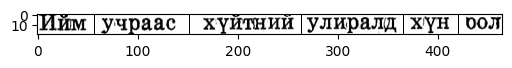

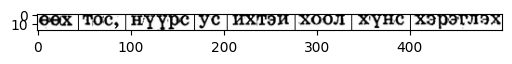

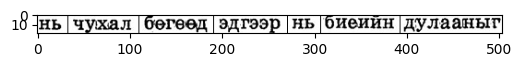

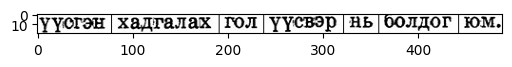

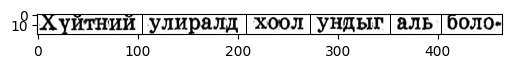

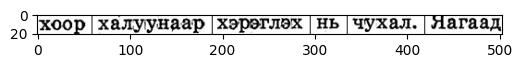

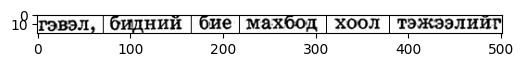

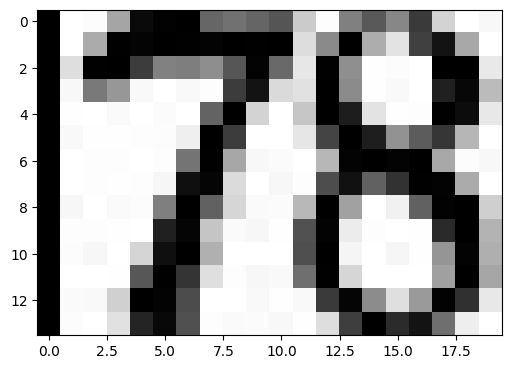

In [10]:
total_text_result = []
for i in range(len(line_images_all)):
    words = word_segmentation(line_images_all[i], True)
    line_text = ""
    for word in words:
        rgb_word = convert_gray_to_rgb(word)
        line_text = line_text + (predict_custom(rgb_word, "./scripts/mn_ocr_paddle/trained_inference/", False)) + " "
    total_text_result.append(line_text)

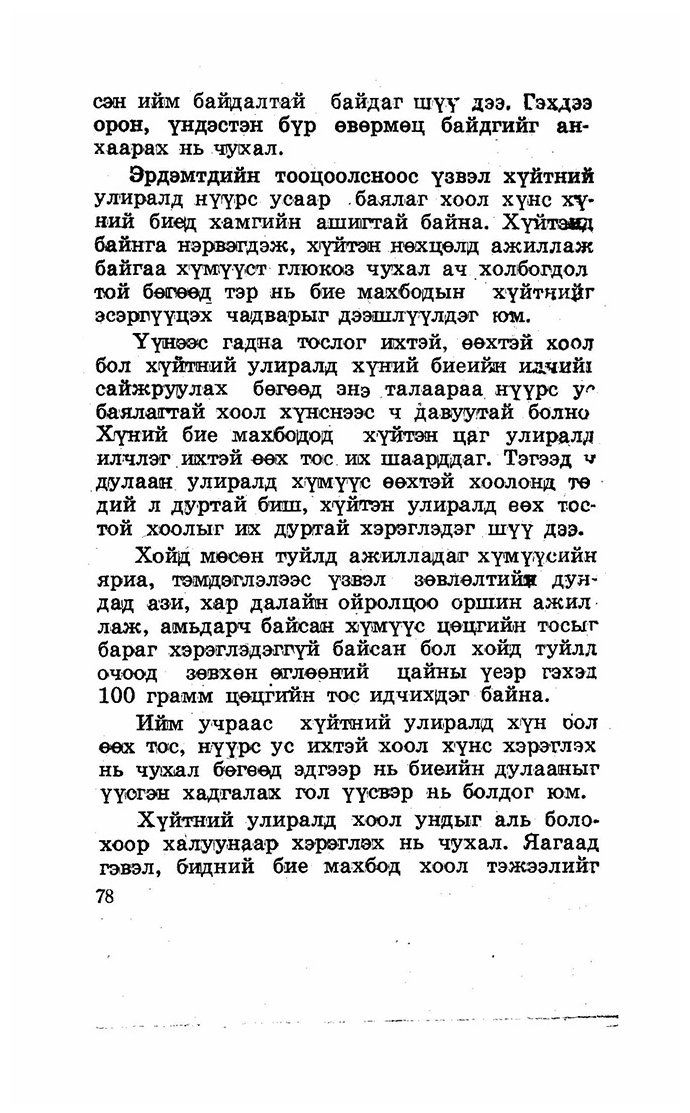

сэн ийм байдалтай. байдаг шүү дээ, Гэхдээ 
орон,. үндэстэн .бүр. өвөрмөц. байдгийг ан- 
хаарах .нь .чухал. 
Эрдэмтдийн тооцоолсноос үзвэл хүйтний 
улиралд .нүгүрс. усаар .баялаг хоол хүнс хү- 
ний биед. хамгийн ашигтай байна. Хүйлэшд 
байнта нэрвэтдэж, хгүйтэн .нөхцөлд. ажиллаж 
байгаа хүмүүст. глюко3 чухал ач. .хол,болдол 
тюй бөгөөд. тэр нь бие Махбодын хүйтнийг 
эсэрлүүцэх чадварыг дээшлгүүлдэг юм. 
Үүнээс гадна тослог. ихтэй, өөхтэй хоол 
бол хгүйтний улиралд. хүний биеийн идчийх 
сайжхруулах бөгөөд. энэ .талаараа. ,нүүрс у- 
баялалтай хоол хүнснээс ч. давуутай .болно 
Хүний бие махбодод хүйтэн цаг улиралд 
илчлэт.ихтэй .өөх тос. их шаарддаг. Тэгээд. ч 
.дулааан. улиралд хүмүүс өөхтэй хоолонд т : 
дий л дуртай .биш, хүйтэн улиралд. вөх тос- 
той хоолыг ИХ дуртай хэрэглэдэг ..шҮҮ дээ- 
Хойд мөсөн туйлд ажилладалг хүмүүсийн 
яриа, тэмдэглэлээс үзвэл зөвлөлтийн дун- 
дад. ,ази, хар ,далайн ойролцоо орш.ин ажил. 
лах, амьдарч. байсан хүмүүс цөцгийн тосыг 
бараг .хэрэтлэдэглүй байсан бо

In [11]:
image = cv2.imread(IMAGE_PATH)
display_image(image)
for i in total_text_result:
    print(i)